In [38]:
import transformers
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from umap import UMAP

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

from huggingface_hub import notebook_login

In [39]:
transformers.logging.set_verbosity_error()
notebook_login()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Login successful
Your token has been saved to /Users/andrewbryant/.huggingface/token
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [19]:
emotions = load_dataset("emotion")
model_checkpoint = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_checkpoint).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Using custom data configuration default
Reusing dataset emotion (/Users/andrewbryant/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)
100%|██████████| 3/3 [00:00<00:00, 496.99it/s]


In [33]:
def extract_hidden_states(batch):
    '''Get hidden state from batch without further training'''
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize='true')
    _fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [20]:
# Pad all samples to the size of the longest sample
# Truncate all to the max input size of the model
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

# Convert columns to pytorch format
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Extract hidden state for each input value
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Loading cached processed dataset at /Users/andrewbryant/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705/cache-dd0f2056c8448e0c.arrow
100%|██████████| 1/1 [00:00<00:00,  1.67ba/s]
Loading cached processed dataset at /Users/andrewbryant/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705/cache-42148ecf162d6c6b.arrow
100%|██████████| 2/2 [02:36<00:00, 78.50s/ba]


In [24]:
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])

y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])

# Scale features
X_scaled = MinMaxScaler().fit_transform(X_train)

mapper = UMAP(n_components=2, metric='cosine').fit(X_scaled)

df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train

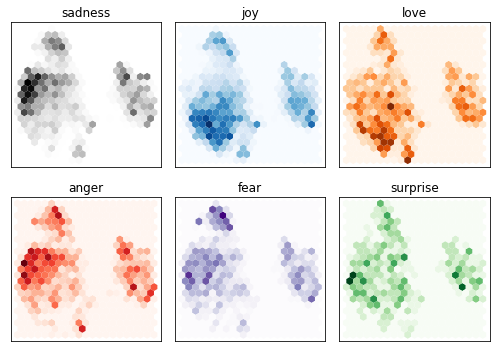

In [25]:
fix, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions['train'].features['label'].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.tight_layout()
plt.show()

Logistic Regression score: 0.6335
Dummy score: 0.352


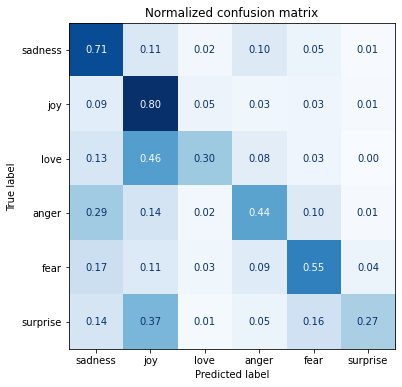

In [32]:
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

print(f'Logistic Regression score: {lr_clf.score(X_valid, y_valid)}')
print(f'Dummy score: {dummy_clf.score(X_valid, y_valid)}')

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

In [ ]:
num_labels = 6
model = (AutoModelForSequenceClassification.from_pretrained(model_checkpoint).to(device))